In [167]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Optimizer

In [168]:
class QNet(nn.Module):
    """
    Neural Network for approximating Q values.
    Input: state-action pair (indexed), shape=(2,)
     1. state index
     2. action index
    Output: Q value
    """
    def __init__(self):
        super(QNet, self).__init__()
        self.fc1 = torch.nn.Linear(2, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [169]:
class QNet_Optimizer:
    """
    w <- w + alpha * delta * grad
    """
    def __init__(self, qnet, alpha):
        self.qnet = qnet
        self.alpha = alpha

    def zero_grad(self):
        for p in self.qnet.parameters():
            if p.grad is not None:
                p.grad.zero_()

    @torch.no_grad()
    def step(self, td_error):
        td_error_scalar = td_error.item()
        for p in self.qnet.parameters():
            if p.grad is not None:
                p.add_(self.alpha * td_error_scalar * p.grad)


In [170]:
class Sarsa_Value(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=0.001, epsilon=0.1):

        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )

        self.alpha = alpha
        self.QNet = QNet()
        self.optimizer = QNet_Optimizer(self.QNet, alpha)

    def choose_action(self, state):
        """
        Choose action under policy
        :param state: current state
        :return: action: chosen action under policy matrix
        """
        state_idx = self.state2idx(state)
        probs = self.policy[state_idx]
        action_idx = np.random.choice(np.arange(len(probs)), p=probs)
        action = self.idx2action(action_idx)
        return action

    def q_value(self, s_idx, a_idx):
        sa = torch.tensor([[s_idx, a_idx]], dtype=torch.float)
        return self.QNet(sa)

    def update_policy(self, s_idx):
        """
        ε-greedy policy improvement
        """
        num_actions = self.num_actions
        q_values = [self.q_value(s_idx, a).item() for a in range(num_actions)]
        best_a = np.argmax(q_values)

        self.policy[s_idx] = np.ones(num_actions) * self.epsilon / num_actions
        self.policy[s_idx][best_a] += 1 - self.epsilon

    def run(self):
        for episode in range(self.num_episodes):

            self.env.reset()
            st = self.env.start_state
            at = self.choose_action(st)

            for t in range(self.episode_length):
                # Take action a_t, observe r_t, s_{t+1}
                s_next, reward, done, _ = self.env.step(at)
                a_next = self.choose_action(s_next)

                # State, action to index
                st_idx = self.state2idx(st)
                at_idx = self.action2idx(at)
                s_next_idx = self.state2idx(s_next)
                a_next_idx = self.action2idx(a_next)


                # Update Q function
                # Q(s_t, a_t)
                q_sa = self.q_value(st_idx, at_idx)

                # Q(s_{t+1}, a_{t+1}) (no gradient)
                with torch.no_grad():
                    q_next = self.q_value(s_next_idx, a_next_idx)

                # TD error δ_t
                td_error = reward + self.gamma * q_next - q_sa

                self.optimizer.zero_grad()
                q_sa.backward()                     # ∇_w q(s_t, a_t)
                self.optimizer.step(td_error)      # w += α δ ∇q

                # policy improvement
                self.update_policy(st_idx)

                if done or st == self.env.target_state:
                    break

                st, at = s_next, a_next

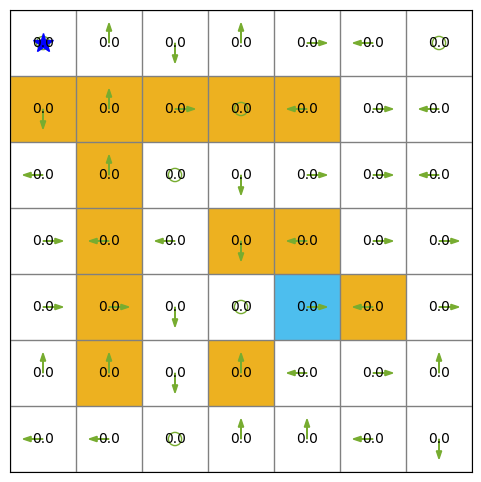

Final Policy:
[[0.04 0.84 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84 0.04 0.04 0.04 0.04]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.84 0.04 0.04 0.04 0.04]
 [0.84

In [171]:
env = GridWorld()
env.reward_step = 0
env.reward_target = 1000
agent = Sarsa_Value(env, epsilon=0.2, gamma=0.99, num_episodes=10, episode_length=1000)
agent.run()
agent.render_static()
print("Final Policy:")
print(agent.get_policy())